In [6]:
import autograd.numpy as np 
from autograd import grad, elementwise_grad, jacobian, make_jvp , holomorphic_grad
from autograd.extend import primitive, defvjp, defjvp
from autograd.scipy.special import erf

import GPy
from GPy.kern import Kern
from GPy.core.parameterization.param import Param

import matplotlib.pyplot as plt
import scipy
from scipy.special import wofz

from copy import deepcopy

## Adding The Fadeeva Function to Autograd

In [7]:
inv_root_pi = 0.56418958354775627928

 
wofz =  primitive(scipy.special.wofz)
defvjp(wofz, lambda ans, x: lambda g:  g * ( -2 * x * wofz(x) + 2.0j * inv_root_pi ) )

## Multioutput Kernel

In [10]:
def vec_digamma_like_q(t1, t2, γd, lq):
    """
    Upsilon function from Alvarez et al. 2013
    
    :param t1[ndarray n1x1]: ndarray of times
        for the dth output 
    :param t2[ndarray n2x1]: ndarray of times
        for the dth output 
    :param γd[scalar]:
    :param lq[scalar]:
    
    :return [ndarray n1xn2]:
    """
    
    t1Minust2 = t1[...,None] - t2
    zdt1 = (t1Minust2) / lq - 0.5 * lq * γd
    zd0 = (-t2[None, ...] ) / lq - 0.5 * lq * γd
    
    term1 = 2 * np.exp( 0.25 * (lq * γd)**2 - (t1Minust2) * γd )
    term2 = np.exp(-(t1Minust2)**2 / lq**2)  * wofz(1.0j * zdt1)
    term3 = np.exp(-(t2[None,...])**2 / lq**2) * np.exp(-t1[..., None] * γd) * wofz(-1.0j * zd0)

    return (term1 - term2 - term3).T


def vec_digamma_like_q_diag(t1, t2, γd, lq):
    """
    Diagonal Upsilon function
    
    :param t1[ndarray nx1]: ndarray of times
        for the dth output 
    :param t2[ndarray nx1]: ndarray of times
        for the dth output 
    :param γd[scalar]:
    :param lq[scalar]:
    
    :return [ndarray nx1]:
    """
    
    t1Minust2 = t1 - t2
    zdt1 = (t1Minust2) / lq - 0.5 * lq * γd
    zd0 = (-t2) / lq - 0.5 * lq * γd
    
    term1 = 2 * np.exp( 0.25 * (lq * γd)**2 - (t1Minust2) * γd )
    term2 = np.exp(-(t1Minust2)**2 / lq**2)  * wofz(1.0j * zdt1)
    term3 = np.exp(-(t2)**2 / lq**2) * np.exp(-t1 * γd) * wofz(-1.0j * zd0)

    return (term1 - term2 - term3).T


def vec_h_q(t1, t2, γd1, γd2, lq):
    """
    h function from Alvarez et al. 2013
    
    :param t1[ndarray n1x1]: ndarray of times
        for the dth output 
    :param t2[ndarray n2x1]: ndarray of times
        for the dth output 
    :param γd1[scalar]:
    :param γd2[scalar]:
    :param lq[scalar]:
    
    :return [ndarray n1xn2]:
    """
    
    num = vec_digamma_like_q(t2, t1, γd1, lq)- np.exp(-γd2 * t1[...,None]) * vec_digamma_like_q(t2, np.array([0]), γd1, lq) 

    denom = γd1 + γd2

    return num / denom

def vec_h_q_diag(t1, t2, γd1, γd2, lq):
    """
    diag h function
    
    :param t1[ndarray nx1]: ndarray of times
        for the dth output 

    :param γd1[scalar]:
    :param γd2[scalar]:
    :param lq[scalar]:
    
    :return [ndarray nx1]:
    """
    
    num = vec_digamma_like_q_diag(t2, t1, γd1, lq)- np.exp(-γd2 * t1) * vec_digamma_like_q_diag(t2, np.array([0]), γd1, lq) 

    denom = γd1 + γd2

    return num / denom


def k_q(t1, t2,lq, Bd1,
        Cd1, Md1, Sqd1,
        Bd2, Cd2, Md2,
        Sqd2 ,h_q=vec_h_q):
    """
    LFM2 kernel for the qth force
    evaluated at (t1, t2, d1, d2)
    
    :param t1[ndarray n1x1]: ndarray of times
        for the dth output 
    :param t2[ndarray n2x1]: ndarray of times
        for the dth output 
    :param lq[scalar]:
    :param Bd1[scalar]: Frequency**2 for d1th output
    :param Cd1[scalar]: Friction for d1th output
    :param Sqd1[scalar]: Sensitivity for the qth
                         force and d1th output
    :param Md1[scalar]: Ignore
    
    
    :return [ndarray n1xn2]:
    """
    α_d1 = 0.5 * Cd1
    ω_d1 = 0.5 * np.sqrt(4 * Bd1 - Cd1**2)
    
    α_d2 = 0.5 * Cd2
    ω_d2 = 0.5 * np.sqrt(4 * Bd2 - Cd2**2)
    
    γd1 = α_d1 + 1.0j * ω_d1
    tγd1 = α_d1 - 1.0j * ω_d1
    
    γd2 = α_d2 + 1.0j * ω_d2
    tγd2 = α_d2 - 1.0j * ω_d2
    
    K_qd = lq  * np.sqrt(np.pi) / (8.0 * ω_d2 * ω_d1)
    
    
    h_tγd2_γd1_t1_t2 = h_q(t1, t2, tγd2, γd1, lq)
    h_γd1_tγd2_t2_t1 = h_q(t2, t1, γd1, tγd2, lq).T
    h_γd2_tγd1_t1_t2 = h_q(t1, t2, γd2, tγd1, lq)
    h_tγd1_γd2_t2_t1 = h_q(t2, t1, tγd1, γd2, lq).T
    

    h_tγd2_tγd1_t1_t2 = h_q(t1, t2, tγd2, tγd1, lq)
    h_tγd1_tγd2_t2_t1 = h_q(t2, t1, tγd1, tγd2, lq).T
    h_γd2_γd1_t1_t2 = h_q(t1, t2, γd2, γd1, lq)
    h_γd1_γd2_t2_t1 = h_q(t2, t1, γd1, γd2, lq).T
    
    
    return K_qd * ((h_tγd2_γd1_t1_t2 + h_γd1_tγd2_t2_t1 + h_γd2_tγd1_t1_t2 + h_tγd1_γd2_t2_t1) 
                  -(h_tγd2_tγd1_t1_t2 + h_tγd1_tγd2_t2_t1 + h_γd2_γd1_t1_t2 + h_γd1_γd2_t2_t1))


def grad_kf(tmat1, tmat2, lvec, bvec, cvec,
            mvec, Smat, debug=False,
            func=k_f_m, gradient_funcs=None):
    """
    grad of kernel function for ode1 one kernel grad_thet(K_ff)
    
    :param tmat1[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param tmat2[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param lvec[ndarray qx1]: single scalar contained in ndarray.
                               Lengthcale for qth force 
    :param bvec[ndarray dx1]: ndarray of B parameters (frequencies^2)
    :param cvec[ndarray dx1]: ndarray of C parameters (friction coeficients)
    :param m[]: Unused mass can completely ignore TODO: remove
    :param Smat[ndarray qxd]: ndarray(matrix) of sensitivities
    
    :returns [list(ndarray Nd x Nd x param_dim)]:
        list of gradients of Kernel matrix 
    """
    
    # Used for cacheing gradient
    if gradient_funcs is None:
        gradient_funcs = [
            jacobian(func, pi)
                          for pi in (2,3,4,5,6)
        ]
    
    gradients = [
        gradient(tmat1,tmat2,
                          lvec, bvec,
                          cvec, 
                          mvec , Smat)
                 for gradient in gradient_funcs
    ]

    return gradients, gradient_funcs


def grad_kf_diag(tmat1, lvec,
                 bvec, cvec
                 mvec, Smat,
                 debug=False,
                 func=None):
    
    
    gradient_funcs = [
        jacobian(func, pi) 
        for pi in (1,2,3,4,5)
    ]
    gradients = [
        gradient(tmat1, lvec, bvec,
                 cvec,  mvec , Smat) 
        for gradient in gradient_funcs
    ]

    return gradients

def grad_kf_check(tmat1, tmat2, lvec, bvec, 
                  cvec, mvec, Smat,
                  epsilon = 0.00001,
                  func=k_f_m, debug=False):
    
    
    if func.__name__ == "vec_k_q_test":
        tmat1 = tmat1.flatten()
        tmat2 = tmat2.flatten()
        
    params = (tmat1,tmat2, lvec, bvec, cvec,  mvec , Smat)
    gradients = []
    for pi in (2,3,4,5,6):
        parep = deepcopy(list(params))
        parep[pi] -= epsilon
        grd = (func(*params) - func(*parep)) / epsilon
        
        gradients.append(grd)
        if debug:
            plt.imshow(grd)
            plt.show()

    return gradients

## Using GPys Coregionalised Regression

(20,) (20,)


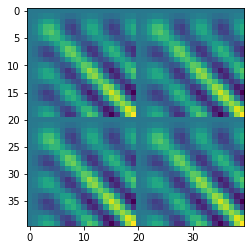

In [11]:
def k_f_m(tmat1, tmat2, l_vec, bvec, cvec, m, Smat, debug=False, d1s=None, d2s=None, xgrad=False):
    """
    kernel function for ode1 one kernel K_ff
    
    :param tmat1[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param tmat2[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param lvec[ndarray qx1]: single scalar contained in ndarray.
            Lengthcale for qth force 
    :param bvec[ndarray dx1]: ndarray of B parameters (frequencies^2)
    :param cvec[ndarray dx1]: ndarray of C parameters (friction coeficients)
    :param m[]: Unused mass can completely ignore TODO: remove
    :param Smat[ndarray qxd]: ndarray(matrix) of sensitivities
    :param d1s[ndarray d<x1]: specific outputs to be evaluated for tmat1
    :param d2s[ndarray d<x1]: specific outputs to be evaluated for tmat2
    
    :returns [ndarray Nd x Nd]: Kernel matrix 
    """
    q = l_vec.shape[0]
    d = bvec.shape[0]
    
    n1 = tmat1[list(tmat1.keys())[0]].shape[0]
    n2 = tmat2[list(tmat2.keys())[0]].shape[0]
    
    if d1s is None:
        d1s = range(d)
    if d2s is None:
        d2s = range(d)
        
    d1_ = len(d1s)
    d2_ = len(d2s)
    
    kf = np.zeros((n1 * d1_, n2 * d2_),
                  dtype=np.complex)
    
    for i_q in range(q):
        l_iq = l_vec[i_q]
        out =  None
        for d1 in d1s:
            for d2 in d2s:

                t1vec = tmat1[d1]
                t2vec = tmat2[d2]

                lq = l_vec[i_q]
                
                Bd1 = bvec[d1]
                Cd1 = cvec[d1]
                Sqd1 = Smat[i_q, d1]
                
                Bd2 = bvec[d2]
                Cd2 = cvec[d2]
                Sqd2 = Smat[i_q, d2]             
                
                cake = Sqd1 * Sqd2 * k_q(t1vec, t2vec,
                                         l_iq, Bd1, Cd1, m,
                                         Sqd1, Bd2, Cd2, m, Sqd2,
                                         h_q=vec_h_q) 
                if out is None:
                    out = cake[None, ...]
                else:
                    out = np.concatenate((out, cake[None,...] ),
                                         axis=0)

        out = out.reshape(d1_, d2_, n1, n2)    
        out = np.transpose(out, 
                           (0,2,1,3)).reshape(n1 *d1_ , 
                                              n2 * d2_)
        kf += out

    return np.real(kf)


def k_f_m_diag(tmat1, l_vec, bvec, cvec, m, Smat, debug=False, d1s=None):
    """
    diagonal kernel function for ode1 one kernel K_ff
    
    :param tmat1[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param lvec[ndarray qx1]: single scalar contained in ndarray.
        Lengthcale for qth force 
    :param bvec[ndarray dx1]: ndarray of B parameters (frequencies^2)
    :param cvec[ndarray dx1]: ndarray of C parameters (friction coeficients)
    :param m[]: Unused mass can completely ignore TODO: remove
    :param svec[ndarray qxd]: ndarray(matrix) of sensitivities
    :param d1s[ndarray d<x1]: specific outputs to be evaluated for tmat1
    
    :returns [ndarray Nd x 1]: diag of Kernel matrix  (vector)
    """
    q = l_vec.shape[0]
    
    n1 = tmat1[list(tmat1.keys())[0]].shape[0]
    
    
    if d1s is None:
        d1s = range(d)

        
    d1_ = len(d1s)
    
    kf = np.zeros(n1 * d1_, dtype=np.complex)
    
    for i_q in range(q):
        l_iq = l_vec[i_q]
        out =  None
        for d1 in d1s:

            t1vec = tmat1[d1]
            t2vec = tmat1[d1]

            lq = l_vec[i_q]

            Bd1 = bvec[d1]
            Cd1 = cvec[d1]
            Sqd1 = Smat[i_q, d1]

            Bd2 = bvec[d1]
            Cd2 = cvec[d1]
            Sqd2 = Smat[i_q, d1]             

            cake = Sqd1 * Sqd2 * k_q(t1vec, t2vec,
                                     l_iq, Bd1, Cd1,
                                     m, Sqd1, Bd2, Cd2,
                                     m, Sqd2 ,
                                     h_q=vec_h_q_diag) 

            if out is None:
                out = cake[None, ...]
            else:
                out = np.concatenate((out, cake[None,...] ),
                                     axis=0)

        out = out.reshape(d1_ * n1)    
        kf += out

    return np.real(kf)


class LFM2M(GPy.kern.Kern):
    """
    d^2y_d(t)/dt + C_d dy_d(t)/dt + B_d y_d(t) = \sum_q S_dq f_q(t)
    
    
    bvec = {B_d} (frequencies)
    Cvec = {C_d} (frictions)
    lengthscales = {l_q} (lengthscales)
    Smat = {S_qd} (Sensitivities)
    """
    
    def __init__(self,input_dim, bvec=np.array([1.0]),
                 lengthscales=np.array([1.0]),
                 Cvec=np.array([1.0]),
                 Smat=np.array([[1.0]]),
                 active_dims=(0,1), debug=False, quick_start=False):
    
        super(LFM2M, self).__init__(input_dim, active_dims, 'LFM2M')
        
        self.d = bvec.shape[0]
        self.q = lengthscales.shape[0]
        self.bvec = Param('bvec', bvec)
        self.lengthscales = Param('lengthscales', lengthscales)
        self.Smat = Param('Smat', Smat)
        self.Cvec = Param('Cvec', Cvec)
        self.link_parameters(self.bvec, self.lengthscales,
                             self.Smat, self.Cvec)
        self.show = False
        self.debug = debug
        self.epsilon = 1e-10
        self.quick_start = quick_start
        self.gradient_funcs = None
    
    @staticmethod
    def preprocess(X):
        d1s = np.unique(X[:,1]).astype(int)
        X_ = {} 
        for d1 in d1s:
            X_[d1] =  X[X[:,1] == d1][:,0] 
        return d1s, X_
    
    def K(self,X,X2):

        if X2 is None: X2 = X
            
        d1s, X_ = self.preprocess(X)
        d2s, X2_ = self.preprocess(X2)
            
        Bd1 = self.bvec
        Cd1 = self.Cvec
        Sqd1 = self.Smat
        lq = self.lengthscales
        k = k_f_m(X_, X2_, lq, Bd1, Cd1, 1.0, Sqd1, d1s=d1s, d2s=d2s)

        return np.real(k)
    
    def Kdiag(self, X):
        
        d1s, X_ = self.preprocess(X)
    
        Bd1 = self.bvec
        Cd1 = self.Cvec
        Sqd1 = self.Smat
        lq = self.lengthscales
        return k_f_m_diag(X_,lq, Bd1, Cd1, 1.0, Sqd1, d1s=d1s)
    
    def update_gradients_diag(self, dL_dKdiag, X):
        
        d1s, X_ = self.preprocess(X)
        
        gradients = grad_kf_diag(X_, self.lengthscales.values, self.bvec.values, 
                                 self.Cvec.values, np.array([1.0]),
                                 self.Smat.values, debug=False,
                                 func=k_f_m_diag)
        
        
        dl = gradients[0]
        db = gradients[1]
        dC = gradients[2]
        dS = gradients[4]
        
        self.bvec.gradient = np.sum(db * dL_dKdiag[..., None], axis=(0))
        self.lengthscales.gradient =  np.sum(dl * dL_dKdiag[..., None], axis=(0))
        self.Cvec.gradient =  np.sum(dC * dL_dKdiag[..., None], axis=(0))
        self.Smat.gradient =  np.sum(dS * dL_dKdiag[..., None, None], axis=(0))
        
    def gradients_X(self, dL_dK, X, X2):
        # Found it difficult to use autograd  for this, implemented finite differences
        # given my usage of Gpys multiout framework lacked flexibility
        ep  = np.array([[self.epsilon,0]])
        dX = (self.K(X, X2) - self.K(X- ep, X2)) / self.epsilon
        
        return np.sum(dL_dK*dX,1)[:,None]      

    def update_gradients_full(self, dL_dK, X, X2):
        if self.quick_start : return None
        if X2 is None: X2 = X      
        
        d1s, X_ = self.preprocess(X)
        d2s, X2_ = self.preprocess(X2)

        gradients = grad_kf(X_, X2_,
                            self.lengthscales.values, self.bvec.values, 
                            self.Cvec.values, np.array([1.0]),
                            self.Smat.values, debug=False, func=k_f_m,
                            gradient_funcs=self.gradient_funcs)
        
        gradients, self.gradient_funcs = gradients
        
        
        dl = gradients[0]
        db = gradients[1]
        dC = gradients[2]
        dS = gradients[4]
        
        if self.debug:
            fig, axs= plt.subplots(2,4)
            axs[0,0].imshow(np.squeeze(dl[:,:,0]))
            axs[0,1].imshow(np.squeeze(db[:,:,0]))
            axs[0,2].imshow(np.squeeze(dC[:,:,0]))
            axs[0,3].imshow(np.squeeze(dS[:,:,0,0]))
            
            axs[1,0].imshow(np.squeeze(dl[:,:,0]))
            axs[1,1].imshow(np.squeeze(db[:,:,1]))
            axs[1,2].imshow(np.squeeze(dC[:,:,1]))
            axs[1,3].imshow(np.squeeze(dS[:,:,0,1]))

            plt.show()
        

        self.bvec.gradient = np.sum(db * dL_dK[..., None],
                                    axis=(0,1))
        self.lengthscales.gradient =  np.sum(dl * dL_dK[..., None],
                                             axis=(0,1))
        self.Cvec.gradient =  np.sum(dC * dL_dK[..., None],
                                     axis=(0,1))
        self.Smat.gradient =  np.sum(dS * dL_dK[..., None, None],
                                     axis=(0,1))
        


debug_multioutput = True


if debug_multioutput:

    d = 2
    n = 20
    b = 10.0
    c = 0.001
    s = 2
    l = 1.0
    bvec_ = np.array([b, b])
    cvec_ = np.array([c, c])
    Smat_ = np.array([[s, s ]])
    lvec_ = np.array([l])
    
    kern = LFM2M(2, bvec=bvec_, lengthscales=lvec_, Cvec=cvec_, Smat=Smat_)
    
    

    t14 = np.linspace(0,5, n).repeat(d).reshape(n,d) + 0
    y = np.sin(t14)
    
    print(t14[:,0].shape, y[:,0].shape)
    t_,y_, output_index = GPy.util.multioutput.build_XY([t14[:,0,None], t14[:,1, None]],[y[:,0,None], y[:,1,None]])
    kk4 = kern.K(t_, t_)
    plt.imshow(kk4)

In [12]:
kern.Kdiag(t_) == np.diag(kern.K(t_,t_))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [15]:
def grad_check_b(tmat1, tmat2, lvec, bvec, cvec, mvec, Smat, epsilon = 0.00001, f = k_f_m):
    bvec_1  = np.copy(bvec)
    bvec_2 = np.copy(bvec)
    bvec_1[0] -= epsilon
    bvec_2[1] -= epsilon
    
    dl1 = f(tmat1, tmat2, lvec, bvec, cvec, mvec, Smat) - f(tmat1, tmat2, lvec, bvec_1, cvec, mvec, Smat)
    dl1 /= epsilon
    
    dl2 = f(tmat1, tmat2, lvec, bvec, cvec, mvec, Smat) - f(tmat1, tmat2, lvec, bvec_2, cvec, mvec, Smat)
    dl2 /= epsilon
    
    return (dl1, dl2)

done init
start opt


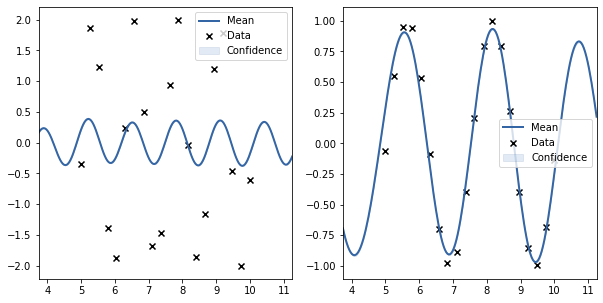

In [28]:
"""
A simple demonstration of coregionalization on two sinusoidal functions.
"""
noise = 1e-5
shift = 5
b = 15
c = 0.001
s = 0.01
bvec_ = np.array([23.5, 6])
cvec_ = np.array([c, c])
Smat_ = np.array([[s, s ]])
lvec_ = np.array([l])

kern = LFM2M(2, bvec=bvec_, lengthscales=lvec_, Cvec=cvec_, Smat=Smat_, debug=True, quick_start=True)

#build a design matrix with a column of integers indicating the output
X1 = np.linspace(0,5, 20) [..., None] + shift +   0.01 * np.random.randn(20)[...,None]
X2 = np.linspace(0,5, 20)[...,None] + shift  +   0.01 * np.random.randn(20)[...,None]

#build a suitable set of observed variables
Y1 = 2 * np.sin(5 * X1) 
Y2 = np.sin(2.5 * X2) 
# SparseGPCoregionalizedRegression
sparse = False
if sparse:
    mco = GPy.models.SparseGPCoregionalizedRegression(X_list=[X1,X2], Y_list=[Y1,Y2], kernel=kern)
else:
    mco = GPy.models.GPCoregionalizedRegression(X_list=[X1,X2], Y_list=[Y1,Y2], kernel=kern)
    
mco.mixed_noise.Gaussian_noise_0.variance = noise
mco.mixed_noise.Gaussian_noise_1.variance = noise

mco.mixed_noise.Gaussian_noise_0.variance.fix()
mco.mixed_noise.Gaussian_noise_1.variance.fix()

mco.kern.lengthscales.constrain_positive() 
mco.kern.Cvec.constrain_positive() 
mco.kern.Smat.constrain_positive() 
    

print("done init")
fig, axs = plt.subplots(1,2, figsize=(10,5))
slices = GPy.util.multioutput.get_slices([X1,X2])
mco.plot(fixed_inputs=[(1,0)],which_data_rows=slices[0],Y_metadata={'output_index':0}, ax=axs[0])
mco.plot(fixed_inputs=[(1,1)],which_data_rows=slices[1],Y_metadata={'output_index':1}, ax=axs[1])

print("start opt")

optimize = False
plot = False

if optimize:
    try:
        mco.optimize('scg', max_iters=100, messages=True)
    except KeyboardInterrupt:
        pass

if plot:
    slices = GPy.util.multioutput.get_slices([X1,X2])
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    mco.plot(fixed_inputs=[(1,0)],which_data_rows=slices[0],Y_metadata={'output_index':0},ax=axs[0])
    mco.plot(fixed_inputs=[(1,1)],which_data_rows=slices[1],Y_metadata={'output_index':1}, ax=axs[1])


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d1c9dcb188>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1d1c9dd8d88>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1d1c9f82e08>]}

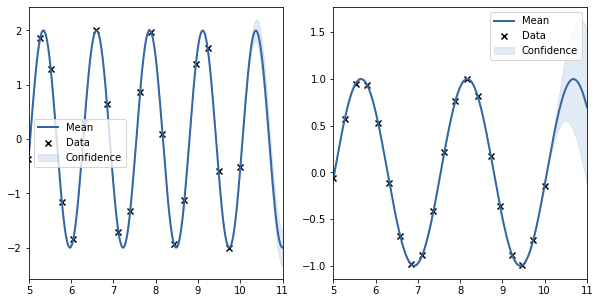

In [12]:
mco.optimize('scg', max_iters=100)
slices = GPy.util.multioutput.get_slices([X1,X2])
fig, axs = plt.subplots(1,2, figsize=(10,5))
mco.plot(plot_limits=(shift, 6 + shift), fixed_inputs=[(1,0)],which_data_rows=slices[0],Y_metadata={'output_index':0}, ax=axs[0])
mco.plot(plot_limits=(shift, 6 + shift), fixed_inputs=[(1,1)],which_data_rows=slices[1],Y_metadata={'output_index':1}, ax=axs[1])


In [13]:
mco.kern.bvec

index,gp.LFM2M.bvec,constraints,priors
[0],24.99833004,,
[1],6.25046190,,


In [29]:
%matplotlib inline
X,Y, output_index = GPy.util.multioutput.build_XY([X1, X2],[Y1, Y2])
plt.imshow(mco.kern.K(X, X))
plt.colorbar()
plt.show()